In [31]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer, make_column_selector

from scripts import DataSet

In [76]:
seed = 42
parameters = {
    'dataset': {
        'target': "JV_default_PCE",
        'group_by': "Cell_stack_sequence"
    },
    'preprocessor': {
        'threshold': 0.25,
        'exclude_sections': [
            "Reference information",
            "Cell definition",
            "Outdoor testing",
            "JV data",
        ],
        'exclude_cols': []
    },
    'model': {
        'objective': "reg:squarederror",
        'eval_metric': ["mae", "rmse"],
        'max_depth': 6,
        'eta': 0.3, # Learning rate
    } # Model parameters for XGBoost. More parameters can be added.
    # https://xgboost.readthedocs.io/en/stable/parameter
}
num_round = 300 # Number iterations for the training algorithm.

In [77]:
dataset = DataSet(**parameters['dataset'])

In [78]:
X, y = dataset.preprocess(**parameters['preprocessor'])

In [79]:
# Define the preprocessor
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1
) # Encodes categorical data using an ordinal encoder.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder

numerical_selector = make_column_selector(
    dtype_include=np.number
) # Selects the numerical features.
categorical_selector = make_column_selector(
    dtype_include=[bool, object]
) # Selects the categorical features.

preprocessor = ColumnTransformer([
    ('numerical', 'passthrough', numerical_selector), # Allows numerical features to pass.
    ('categorical', encoder, categorical_selector), # Encodes categorical features.
]) # Transforms numerical and categorical data separately.
preprocessor

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000012A84966330>),
                                ('categorical',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000012A823A4560>)])

In [80]:
# The preprocessor creates a transformed version of the data without human readable feature name. Replace these with the original feature names.
all_columns = list(X.select_dtypes(np.number).columns) + list(X.select_dtypes([bool, object]).columns) # Create a list of feature names.

X_transformed = pd.DataFrame(preprocessor.fit_transform(X, y)) # Transform data
X_transformed.columns = all_columns # Replace column names


gkf = GroupKFold(n_splits=2)
train, test = next(gkf.split(X_transformed, y, groups=dataset.groups))

X_train, X_test = X_transformed.loc[train], X_transformed.loc[test]
y_train, y_test = y[train], y[test]

In [81]:
###--- Define the Model ---###
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)
evals = [(dtrain, 'train'), (dval, 'valid')] # evaluations that log to neptune.
results = {}
model = xgb.train(
    params=parameters['model'],
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=results,
    callbacks=[],
)

[0]	train-mae:3.85469	train-rmse:4.67891	valid-mae:4.04498	valid-rmse:4.93289
[1]	train-mae:3.58954	train-rmse:4.39232	valid-mae:3.77390	valid-rmse:4.64814
[2]	train-mae:3.40824	train-rmse:4.20552	valid-mae:3.60655	valid-rmse:4.48751
[3]	train-mae:3.27999	train-rmse:4.07829	valid-mae:3.50799	valid-rmse:4.39572
[4]	train-mae:3.17762	train-rmse:3.97517	valid-mae:3.45553	valid-rmse:4.34938
[5]	train-mae:3.09195	train-rmse:3.89111	valid-mae:3.38850	valid-rmse:4.28446
[6]	train-mae:3.03353	train-rmse:3.84078	valid-mae:3.34907	valid-rmse:4.25461
[7]	train-mae:2.98120	train-rmse:3.79047	valid-mae:3.31298	valid-rmse:4.21995
[8]	train-mae:2.93019	train-rmse:3.73672	valid-mae:3.27875	valid-rmse:4.18503
[9]	train-mae:2.89896	train-rmse:3.70425	valid-mae:3.26055	valid-rmse:4.16763
[10]	train-mae:2.86831	train-rmse:3.67183	valid-mae:3.25172	valid-rmse:4.15915
[11]	train-mae:2.82400	train-rmse:3.62590	valid-mae:3.24501	valid-rmse:4.14560
[12]	train-mae:2.78568	train-rmse:3.58440	valid-mae:3.23127	va

In [82]:
train_results = pd.DataFrame(results['train'])
valid_results = pd.DataFrame(results['valid'])
train_results.columns = ['train-mae', 'train-rmse']
valid_results.columns = ['valid-mae', 'valid-rmse']

train-mae
train-rmse
valid-mae
valid-rmse


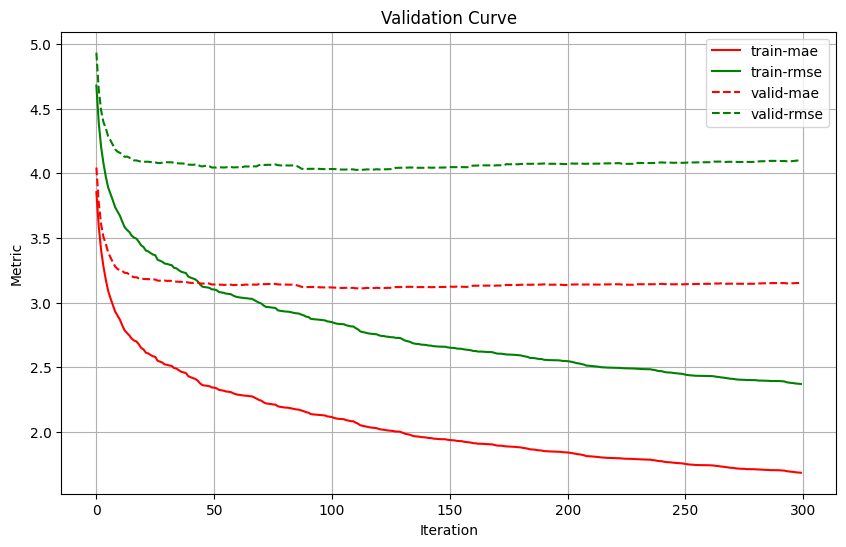

In [85]:
# Define line styles
styles = ['-', '-', '--', '--']
colors = ['r', 'g', 'r', 'g']
names = ['train-mae', 'train-rmse', 'valid-mae', 'valid-rmse']

full_results = pd.concat([train_results, valid_results], axis=1)

# Plotting
plt.figure(figsize=(10, 6))
for i, column in enumerate(full_results.columns):
    print(column)
    plt.plot(
        full_results.index, full_results[column],
        linestyle=styles[i % len(styles)],
        color=colors[i % len(colors)],
        label=names[i % len(names)]
    )

plt.xlabel('Iteration')
plt.ylabel('Metric')
plt.title('Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Generate predictions from the trained model.
y_pred = model.predict(dval)
pred_actual = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
})
pred_actual

,y_true,y_pred
0,0.00,-0.670154
1,0.00,3.635670
2,0.13,-2.719723
3,0.12,-1.973203
4,0.10,-1.379298
...,...,...
42238,30.40,15.396533
42239,18.70,17.234247
42240,33.70,13.854216
42241,29.20,13.854216


In [50]:
# Generate shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

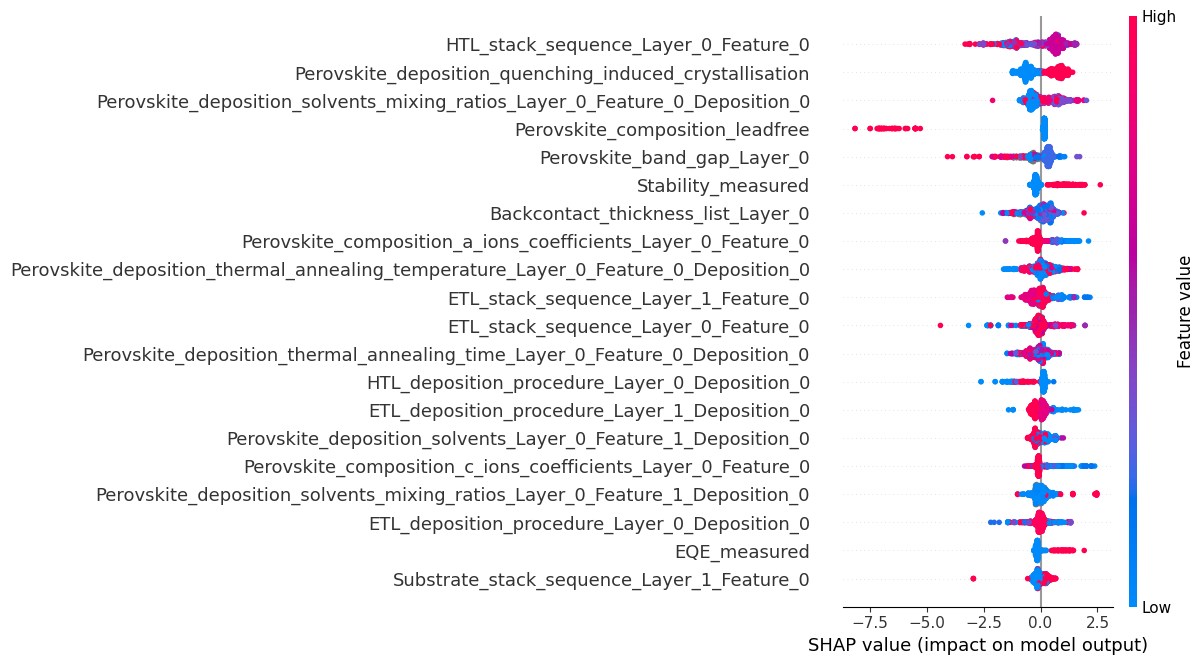

In [51]:
# Plotting
fig = plt.figure()
shap.summary_plot(
    shap_values[:1000, :],
    X_transformed.iloc[:1000, :],
    plot_size=[12, 6.75],
    show=True,
)

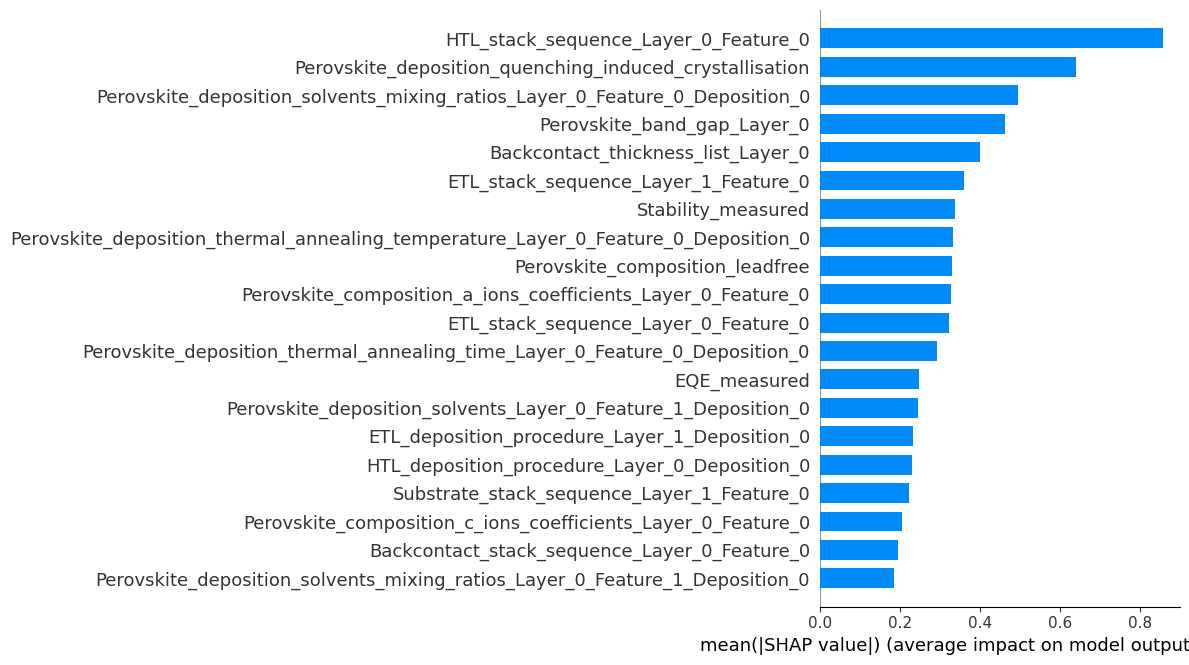

In [52]:
fig = plt.figure()
shap.summary_plot(
    shap_values,
    X_transformed,
    plot_type="bar",
    plot_size=[12, 6.75],
    show=True,    
)

In [28]:
from scripts import DATABASE
from sklearn.model_selection import GroupKFold

DATABASE.load_data()
DATABASE.data.head()

,Ref_ID,Ref_ID_temp,Ref_name_of_person_entering_the_data,Ref_data_entered_by_author,Ref_DOI_number,Ref_lead_author,Ref_publication_date,Ref_journal,Ref_part_of_initial_dataset,Ref_original_filename_data_upload,...,Outdoor_PCE_Tse80,Outdoor_PCE_after_1000_h,Outdoor_power_generated,Outdoor_link_raw_data_for_outdoor_trace,Outdoor_detaild_weather_data_available,Outdoor_link_detailed_weather_data,Outdoor_spectral_data_available,Outdoor_link_spectral_data,Outdoor_irradiance_measured,Outdoor_link_irradiance_data
0,1,1,Adam Hultqvist,False,10.1021/jp5126624,Sabba et al.,2015-01-06,The Journal of Physical Chemistry C,True,Historic dataset on 2020 11 22_v7.xlsx,...,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN
1,2,2,Adam Hultqvist,False,10.1021/jp5126624,Sabba et al.,2015-01-06,The Journal of Physical Chemistry C,True,Historic dataset on 2020 11 22_v7.xlsx,...,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN
2,3,3,Adam Hultqvist,False,10.1021/jp5126624,Sabba et al.,2015-01-06,The Journal of Physical Chemistry C,True,Historic dataset on 2020 11 22_v7.xlsx,...,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN
3,4,4,Adam Hultqvist,False,10.1021/jp5126624,Sabba et al.,2015-01-06,The Journal of Physical Chemistry C,True,Historic dataset on 2020 11 22_v7.xlsx,...,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN
4,5,5,Adam Hultqvist,False,10.1021/jp5126624,Sabba et al.,2015-01-06,The Journal of Physical Chemistry C,True,Historic dataset on 2020 11 22_v7.xlsx,...,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN
